# Step 0: 固定随机种子

# Step 1: Load data

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import torch
import random

# Step 0: 固定随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"✅ 已设置随机种子: {seed}")


import sys
sys.path.append("/home/vs_theg/ST_program/cell_program_deconvolution/src/")  # 添加上级目录到Python路径
from deconvolution.model import DeconvModel
from deconvolution.graph_utils import build_laplacian
from deconvolution.train import train_model
from deconvolution.visualize import plot_spatial, plot_program_contribution

sys.path.append("/home/vs_theg/ST_program/CellType_GP/src")  # 添加上级目录到Python路径
from train_utils import train_model_2

# Step 1: Load data
data = np.load("/home/vs_theg/ST_program/CellType_GP/data/preprocessing_outputs/spot_data_full.npz", allow_pickle=True)
Y = torch.tensor(data["visium_score"], dtype=torch.float32)         # (P, S)
X = torch.tensor(data["spot_cluster_fraction_matrix"], dtype=torch.float32)         # (S, T)
coords = data["coords"]                                  # (S, 2)

spot_names = data['spot_names']
celltype_names = data['celltype_names']
program_names = data['program_names']

# 查看数据前几行
print("Y (shape: {}):".format(Y.shape))
print(Y[:5, :5])  # 查看前5行前5列
print("\nX (shape: {}):".format(X.shape))
print(X[:5, :6])  # 查看前5行前5列
print("\ncoords (shape: {}):".format(coords.shape))
print(coords[:5])  # 查看前5行

P, S = Y.shape
S_, T = X.shape
assert S == S_

L = build_laplacian(coords, k=6)
model = DeconvModel(T=T, P=P, S=S, X_tensor=X, L=L)


✅ 已设置随机种子: 42
Y (shape: torch.Size([13, 3953])):
tensor([[0.2741, 0.2692, 0.2627, 0.1067, 0.5122],
        [0.2596, 0.2071, 0.3248, 0.0480, 0.1580],
        [0.2877, 0.6234, 0.3451, 0.2823, 0.2601],
        [0.2727, 0.3972, 0.2551, 0.4064, 0.2967],
        [0.3123, 0.5241, 0.4290, 0.3826, 0.3049]])

X (shape: torch.Size([3953, 6])):
tensor([[0.0000, 0.0714, 0.0000, 0.8571, 0.0000, 0.0714],
        [0.0213, 0.1702, 0.1915, 0.4043, 0.1064, 0.1064],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.2222, 0.1111, 0.0000, 0.5556, 0.0000, 0.1111],
        [0.0000, 0.0455, 0.0000, 0.9545, 0.0000, 0.0000]])

coords (shape: (3953, 2)):
[[13355. 16640.]
 [ 8845. 12067.]
 [14716. 15518.]
 [11404. 12365.]
 [ 7452.  9059.]]


## 检查拉普拉斯矩阵的半正定性

In [6]:
eigvals = torch.linalg.eigvalsh(L)
print(eigvals.min().item(), eigvals.max().item(), torch.allclose(L, L.T, atol=1e-6))
# 输出最小特征值、最大特征值、对称性检查结果，确保拉普拉斯矩阵L是半正定的

2.034969242004081e-07 1.4985674619674683 True


# Step 2: Train model

In [7]:
import os
os.chdir('/home/vs_theg/ST_program/CellType_GP/data')

In [ ]:
# Step 2: Train model
# train_model(model,  Y_obs=Y, num_epochs=6000, lr=1e-4, lambda1=0, lambda2=0)

# 若需step5, 可取消下一行注释训练
history = train_model_2(model,  Y_obs=Y, num_epochs=1000, lr=1e-3, lambda1=0.5, lambda2=0)  # lambda1=（0,1e-6,1e-2,0.5）

Epoch    0 | Loss 77070.7266 | Recon 0.1232 | LR 1.00e-03:   0%| | 1/3000 [00:08<6:57:04,  8.34s/it]

🔍 [中间层检查] Epoch 0
  Y_tps  mean=4.989164e-01, std=2.887343e-01
  Y_pred mean=4.985705e-01, std=2.273635e-01


Epoch  147 | Loss 56073.9609 | Recon 0.0793 | LR 1.00e-03:   5%| | 148/3000 [24:07<7:44:54,  9.78s/i


KeyboardInterrupt: 

In [5]:
print(history)

{'total_loss': array([1.23186447e-01, 1.22621417e-01, 1.22058406e-01, ...,
       1.79186785e-07, 1.77577633e-07, 1.75982294e-07]), 'recon_loss': array([1.23186447e-01, 1.22621417e-01, 1.22058406e-01, ...,
       1.79186785e-07, 1.77577633e-07, 1.75982294e-07]), 'l1_loss': array([154141.203125, 154055.015625, 153969.015625, ..., 131290.859375,
       131290.859375, 131290.84375 ]), 'smooth_loss': array([25752.93164062, 25734.34765625, 25715.96679688, ...,
       27191.69335938, 27191.71289062, 27191.73242188]), 'lr': array([0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001]), 'best_loss': 4.94072583023808e-06, 'best_epoch': 1782}


# Step 3: 生成最终预测结果 Y_pred_df


In [7]:
# 加载最优epoch的结果

import torch

# best_model_path = os.path.join(save_dir, "best_model.pt")
state_dict = torch.load('/home/vs_theg/ST_program/CellType_GP/data/training_logs/4/best_model.pt')
model.load_state_dict(state_dict)

print(f"✅ 已加载最优模型（epoch={history['best_epoch']}, loss={history['best_loss']:.6f}）")


✅ 已加载最优模型（epoch=1782, loss=0.000005）


In [8]:
with torch.no_grad():
    Y_pred_best = model.forward()
    print("Y_pred_best mean:", Y_pred_best.mean().item())


Y_pred_best mean: 0.2909089922904968


In [9]:
import torch
import numpy as np
import pandas as pd

# Step 3: 生成最终预测结果
with torch.no_grad():
    Y_pred = model.forward().detach().cpu().numpy()  # shape: (P, S)

# 转置成 (S, P) 方便与 spot 对齐
Y_pred_df = pd.DataFrame(Y_pred.T, index=data['spot_names'], columns=data['program_names'])

Y_pred_df
# output_path_pred = '/home/vs_theg/ST_program/CellType_GP/data/training_logs/2/train_result(pred_matrix).csv'
# Y_pred_df.to_csv(output_path_pred)
# print(f"✅ 已生成预测矩阵：{Y_pred_df.shape}")
# print(f"👉 保存路径: {output_path_pred}")


,B_cell_score,T_cell_score,DCIS_Tumor_score,Endothelial_score,Invasive_Tumor_score,IRF7+_DCs_score,LAMP3+_DCs_score,Macrophages_score,Mast_score,Myoepi_ACTA2+_score,Myoepi_KRT15+_score,Perivascular-Like_score,Stromal_score
AACACGTGCATCGCAC-1,0.274057,0.259560,0.287749,0.272722,0.312345,0.344145,0.213144,0.397100,0.409188,0.176970,0.135937,0.327647,0.618789
AACACTTGGCAAGGAA-1,0.269209,0.207147,0.623374,0.397175,0.524094,0.312375,0.313558,0.408017,0.184700,0.739782,0.413694,0.432451,0.347488
AACAGGAAGAGCATAG-1,0.262670,0.324825,0.345071,0.255104,0.429125,0.287344,0.432405,0.485653,0.418350,0.393704,0.259235,0.425000,0.489332
AACAGGATTCATAGTT-1,0.107298,0.051024,0.282323,0.406395,0.382635,0.139627,0.245880,0.323018,0.248225,0.229669,0.183081,0.295997,0.589177
AACAGGTTATTGCACC-1,0.512169,0.158791,0.260148,0.296674,0.305033,0.322542,0.418281,0.523913,0.258362,0.252987,0.206964,0.297242,0.658361
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGGAACCTTCCGC-1,0.231903,0.116308,0.263530,0.270255,0.359070,0.162202,0.130615,0.353660,0.099615,0.347100,0.107520,0.292947,0.524267
TGTTGGAACGAGGTCA-1,0.074870,0.115753,0.309473,0.418125,0.278746,0.227590,0.276026,0.473332,0.199352,0.313807,0.217147,0.405108,0.540682
TGTTGGAAGCTCGGTA-1,0.476516,0.532684,0.457137,0.415692,0.476219,0.461754,0.272580,0.591221,0.214741,0.417795,0.232430,0.367407,0.419989
TGTTGGATGGACTTCT-1,0.198141,0.203521,0.480401,0.240035,0.672634,0.224808,0.219128,0.356467,0.050591,0.267523,0.187832,0.256396,0.277721


# Step 4: 导出每个program的贡献矩阵

In [12]:
# ==== Step 4 (new): 导出每个 program 的贡献矩阵，形状 S × (T*P) ====
import torch
import numpy as np
import pandas as pd

with torch.no_grad():
    # 取出模型参数与输入基底
    Y_tps = model.Y_tps.detach().cpu()     # (T, P, S)
    X_spot_t = model.X.detach().cpu()      # (S, T)

    T, P, S = Y_tps.shape

    # 计算每个 program 的贡献: contrib[s,t,p] = X[s,t] * Y_tps[t,p,s]
    # 先得到 (S, T, P) 的张量
    contrib_stp = torch.einsum('st,tps->stp', X_spot_t, Y_tps)  # (S, T, P)

    # 校验：沿 T 求和应当等于 Y_pred^T (S,P)
    Y_pred = model.forward().detach().cpu().T  # (S, P)
    recon_err = (contrib_stp.sum(dim=1) - Y_pred).abs().max().item()
    print(f"✅ 复核：max|sum_t(contrib) - Y_pred| = {recon_err:.3e}")

    # 展平为 (S, T*P)，并按 (celltype, program) 生成列名
    contrib_flat = contrib_stp.reshape(S, T * P)  # (S, T*P)

# 准备索引与列名（与你之前的一致）
spot_names = data['spot_names']          # 长度 S
celltype_names = data['celltype_names']  # 长度 P
program_names = data['program_names']    # 长度 T

# 注意列名次序需与 reshape 次序一致：这里是先沿 P 慢，T 快 or 反之？
# 上面 reshape 是 (S, T, P) -> (S, T*P)，即 T 维在前、P 维在后。
# 若你希望列名顺序为 [ct1+pg1, ct1+pg2, ...]，那就先交换维度为 (S, P, T) 再展平：
contrib_spt = contrib_stp.permute(0, 2, 1).contiguous()  # (S, P, T)
contrib_flat = contrib_spt.reshape(S, P * T)             # (S, P*T)

columns = [f"{ct}+{pg}" for ct in celltype_names for pg in program_names]
df_contrib = pd.DataFrame(contrib_flat.numpy(), index=spot_names, columns=columns)

out_path = '/home/vs_theg/ST_program/CellType_GP/data/training_logs/4/train_resulu.csv'
df_contrib.to_csv(out_path)
print(f"📦 已导出 program 级贡献矩阵：{df_contrib.shape} → {out_path}")


✅ 复核：max|sum_t(contrib) - Y_pred| = 5.960e-08
📦 已导出 program 级贡献矩阵：(3953, 78) → /home/vs_theg/ST_program/CellType_GP/data/training_logs/4/train_resulu.csv


In [13]:
df_contrib

,Endothelial+B_cell_score,Endothelial+T_cell_score,Endothelial+DCIS_Tumor_score,Endothelial+Endothelial_score,Endothelial+Invasive_Tumor_score,Endothelial+IRF7+_DCs_score,Endothelial+LAMP3+_DCs_score,Endothelial+Macrophages_score,Endothelial+Mast_score,Endothelial+Myoepi_ACTA2+_score,...,lymphocyte+Endothelial_score,lymphocyte+Invasive_Tumor_score,lymphocyte+IRF7+_DCs_score,lymphocyte+LAMP3+_DCs_score,lymphocyte+Macrophages_score,lymphocyte+Mast_score,lymphocyte+Myoepi_ACTA2+_score,lymphocyte+Myoepi_KRT15+_score,lymphocyte+Perivascular-Like_score,lymphocyte+Stromal_score
AACACGTGCATCGCAC-1,0.000000,0.014843,0.000000,0.268675,0.000000,-0.009461,0.000000,0.003800,0.000000,0.273817,...,0.000000,0.309640,0.000000,-0.013326,0.000000,0.010245,0.000000,0.553278,0.000000,0.055266
AACACTTGGCAAGGAA-1,0.014704,0.042590,0.011439,0.182022,-0.000111,0.018566,0.014901,0.041194,0.114710,-0.031898,...,0.026080,0.233350,0.018999,0.019580,0.008768,0.014856,0.036977,0.186781,0.008681,0.091426
AACAGGAAGAGCATAG-1,0.000000,0.000000,0.000000,0.262670,0.000000,0.000000,0.000000,0.000000,0.000000,0.324825,...,0.000000,0.425000,0.000000,0.000000,0.000000,0.000000,0.000000,0.489332,0.000000,0.000000
AACAGGATTCATAGTT-1,0.077944,0.021272,0.000000,0.044343,0.000000,-0.036260,-0.063067,-0.025053,0.000000,0.158086,...,0.000000,0.234847,0.000000,0.049481,0.103317,0.057137,0.000000,0.407853,0.000000,0.020869
AACAGGTTATTGCACC-1,0.000000,0.018242,0.000000,0.493927,0.000000,0.000000,0.000000,-0.014053,0.000000,0.172843,...,0.000000,0.255076,0.000000,0.000000,0.000000,0.016973,0.000000,0.641388,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGGAACCTTCCGC-1,0.000000,0.000000,0.000000,0.231903,0.000000,0.000000,0.000000,0.000000,0.000000,0.116308,...,0.000000,0.292947,0.000000,0.000000,0.000000,0.000000,0.000000,0.524267,0.000000,0.000000
TGTTGGAACGAGGTCA-1,0.000000,-0.005729,0.000000,0.080600,0.000000,0.000000,0.000000,0.079113,0.000000,0.036639,...,0.000000,0.365728,0.000000,0.000000,0.000000,0.034141,0.000000,0.506541,0.000000,0.000000
TGTTGGAAGCTCGGTA-1,0.032718,0.050888,0.019780,0.018617,0.012219,0.342294,0.033285,0.009530,0.010813,0.200149,...,0.001983,0.185101,0.015527,0.002236,0.041898,0.074682,0.008372,0.002607,0.011525,0.280906
TGTTGGATGGACTTCT-1,0.021397,0.051135,0.000000,0.019212,0.089503,0.016894,0.032582,0.003321,0.000000,0.012287,...,0.000000,0.035145,0.180356,0.006272,0.054613,0.061858,0.000000,0.020195,0.114364,0.026692


# Step 4: 可视化结果

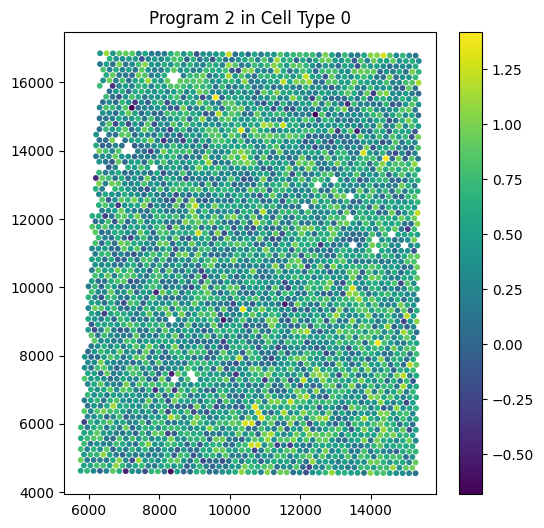

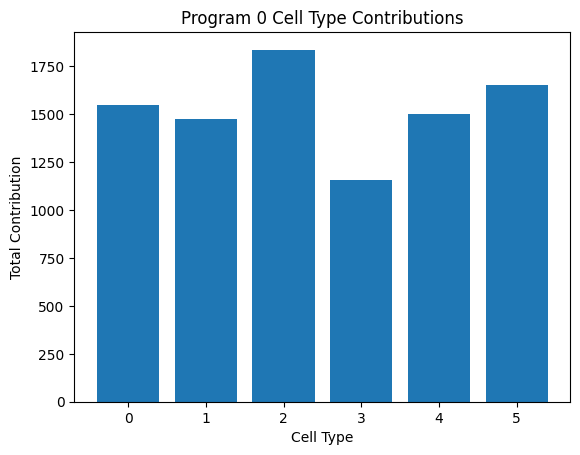

In [15]:
# Step 4: Visualize results
Y_tps = model.Y_tps.detach()
plot_spatial(Y_tps, coords, cell_type=0, program_index=2)
plot_program_contribution(Y_tps, program_index=0)


import numpy as np
import pandas as pd


# Step 5: Convert Y_tps to wide DataFrame and save
# 假设 Y_tps 形状为 (T, P, S)
Y_tps = model.Y_tps.detach().cpu().numpy()
T, P, S = Y_tps.shape

# 确保索引
spot_names = data['spot_names']
celltype_names = data['celltype_names']
program_names = data['program_names']


# 1️⃣ 重新排列维度： (S, T, P)
Y_tps_reordered = np.transpose(Y_tps, (2, 0, 1))  # S x T x P

# 2️⃣ 展平每个 spot 的 (T×P) 向量
Y_tps_flat = Y_tps_reordered.reshape(S, T * P)

# 3️⃣构造 DataFrame
columns = [f"{ct}+{pg}" for ct in celltype_names for pg in program_names]
y_tps_matrix_df = pd.DataFrame(Y_tps_flat, index=spot_names, columns=columns)

# # 4️⃣ 保存结果
# output_path = '/home/vs_theg/ST_program/CellType_GP/data/notebook_outputs/train1000_342_result(wide).csv'
# y_tps_matrix_df.to_csv(output_path, index=True)
# print(f"✅ 已生成矩阵表：{y_tps_matrix_df.shape[0]} × {y_tps_matrix_df.shape[1]}")
# print(f"👉 保存路径: {output_path}")



In [16]:
y_tps_matrix_df

,Endothelial+B_cell_score,Endothelial+T_cell_score,Endothelial+DCIS_Tumor_score,Endothelial+Endothelial_score,Endothelial+Invasive_Tumor_score,Endothelial+IRF7+_DCs_score,Endothelial+LAMP3+_DCs_score,Endothelial+Macrophages_score,Endothelial+Mast_score,Endothelial+Myoepi_ACTA2+_score,...,lymphocyte+Endothelial_score,lymphocyte+Invasive_Tumor_score,lymphocyte+IRF7+_DCs_score,lymphocyte+LAMP3+_DCs_score,lymphocyte+Macrophages_score,lymphocyte+Mast_score,lymphocyte+Myoepi_ACTA2+_score,lymphocyte+Myoepi_KRT15+_score,lymphocyte+Perivascular-Like_score,lymphocyte+Stromal_score
AACACGTGCATCGCAC-1,0.882269,0.298372,0.677642,0.717133,0.370031,0.883649,0.081077,0.596643,0.724189,0.973749,...,-0.291643,0.544635,-0.409302,0.254433,0.510269,0.182676,0.254781,0.616516,-0.186569,0.773721
AACACTTGGCAAGGAA-1,0.691075,0.700329,0.716057,-0.128532,0.847739,0.675450,0.282375,0.602777,0.020031,0.232830,...,0.300849,0.036233,0.244253,0.402663,0.120547,0.141762,0.191135,0.214085,0.184048,0.859404
AACAGGAAGAGCATAG-1,0.382864,0.738580,0.257656,0.344439,0.793542,0.609370,0.116802,0.321977,0.130421,0.777261,...,0.940869,0.164958,0.969925,0.225564,0.651767,0.832590,0.477816,0.495012,0.782581,0.015478
AACAGGATTCATAGTT-1,0.350749,-0.283800,0.271056,0.391211,0.628870,-0.128384,0.650912,0.843398,0.001412,0.346343,...,0.182915,0.480084,0.620891,-0.241733,0.334100,0.537265,-0.331602,0.047351,0.445325,0.187819
AACAGGTTATTGCACC-1,0.390448,0.490025,0.312839,0.315508,0.062482,0.817790,0.796522,0.116724,0.439357,0.196141,...,0.300502,0.350463,0.072320,0.786351,0.059530,0.425919,0.713496,0.788901,0.296700,0.498468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGGAACCTTCCGC-1,0.473746,0.518651,0.395452,0.533089,0.256375,0.470841,0.183293,0.215124,0.636145,0.721337,...,0.466462,0.937316,0.686606,0.834581,0.067261,0.626670,0.956790,0.000920,0.891482,0.500243
TGTTGGAACGAGGTCA-1,0.340976,0.746484,0.246313,0.301264,0.502325,0.339842,0.972598,0.045888,0.318160,0.645856,...,0.531803,0.563485,0.874524,0.407082,0.274118,0.620655,0.361884,0.953329,0.530521,0.980280
TGTTGGAAGCTCGGTA-1,0.637999,0.649064,0.499303,0.404902,0.945909,0.956227,-0.071819,0.431361,0.453544,1.019653,...,0.283366,0.220264,0.394841,0.176542,0.831905,0.536433,0.397642,0.082164,0.004714,0.592179
TGTTGGATGGACTTCT-1,0.299557,0.456149,0.654237,0.426138,-0.062579,0.368713,0.476932,0.577954,0.357086,0.000163,...,0.210612,0.269675,-0.429197,0.954601,0.187193,0.473013,0.175569,-0.345551,0.175620,0.747371
